# Youtube Video Performance

## Project Overview

### Introduction

Youtube is one of the largest and most popular search engines in the world. With billions of searches and active users each month, Youtube has attracted many content creators in a variety of topics, such as beauty and lifestyle, travel, food, etc. For content creators, it is always very hepful to understand the drivers of views and/or engagement.

As I am personally interested in travelling, I dedicate this project to exploring the relationship between various metrics and views by analyzing 10 most famous Youtube travel channels. This project will entail Exploratory Data Analysis (EDA) and some statistical testing to provide insights into this topic.

### Objectives

* Get familiar with Youtub API and learn how to obtain video data.
* Analyze video data to find answers to a variety of questions:
    * Does the number of likes and comments matter for a video to get more views?
    * Does the video duration matter for views and interaction (likes/ comments)?
    * Does title length matter for views?
    * How many tags do good performing videos have? What are the common tags among these videos?
    * Across all the creators I take into consideration, how often do they upload new videos? On which days in the week? Which day(s) has the most views?
* Use two-sample t-test to find where having caption matters for views.
* Use NLP techniques to discover:
    * Which popular topics are being covered in the videos (e.g. using wordcloud for video titles)?


### Data

I created my own dataset for this project using Youtube API. Due to the quota limit, I chose to collect data of 10 famous travel channels, including: 
* The Endless Adventure
* Abroad in Japan
* Drew Binsky
* Hey Nadine
* Wolters World
* Adventures of A+K
* Flying The Nest
* Kara and Nate
* Indigo Traveller
* FunForLouis

The details of data collection are outlined in the following section.

## Data Creation with Youtube API

Overview of the steps to accquire the data:
* Creating a project on Google Developers Console
* Requesting an authorization credential (API key) 
* Enabling Youtube API for my application, so that I can send API requests to Youtube API services
* Obtaining channels' IDs by checking their channel information on Youtube 
* Writing functions to get channel statistics via the API

In [1]:
api_key = [hidden]

In [193]:
# Import necessary libraries
from googleapiclient.discovery import build
from IPython.display import JSON
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser
import isodate
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
import statsmodels.api as sm

In [119]:
# Import NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carmennguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/carmennguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Creating a list of channel IDs obtained from Youtube.

In [5]:
channel_ids = ['UCB-Ps5DdRsVAcml-Y43o7RQ',
                'UC4ijq8Cg-8zQKx8OH12dUSw',
                'UC0Ize0RLIbGdH5x4wI45G-A',
                'UCVrvnobbNGGMsS5n2mJwfOg',
                'UCFr3sz2t3bDp6Cux08B93KQ',
                'UCEDrRCC0qRtPd5-sSa1hajw',
                'UCU2XpPnwebf9VwOuddBb9NQ',
                'UC3CxEBKx2l38nl1_SFsC2gg',
                'UCHL9bfHTxCMi-7vfxQ-AYtg',
                'UCXulruMI7BHj3kGyosNa0jA']

In [9]:
api_service_name = "youtube"
api_version = "v3"
youtube = build(api_service_name, api_version, developerKey=api_key)


## Channel Statistics

First, let's create a function to get channel statistics.

In [7]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    # loop through items
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

Run this function to get the channel statistics.

In [157]:
channel_data = get_channel_stats(youtube, channel_ids)
channel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   channelName  10 non-null     object
 1   subscribers  10 non-null     object
 2   views        10 non-null     object
 3   totalVideos  10 non-null     object
 4   playlistId   10 non-null     object
dtypes: object(5)
memory usage: 532.0+ bytes


Now that we've got our channel data, we see that the count columns are not in the right format. Let's convert them to numeric values.

In [11]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

Let's take a look at the number of subscribers per channel to have a view of how popular the channels are when compared with one another.

In [35]:
# Creating a set of colors for visualization
color = ['lightblue', 'bisque', 'plum', 'lightcoral', 'yellowgreen', 'olive',
        'lightpink', 'slateblue', 'turquoise', 'gold']

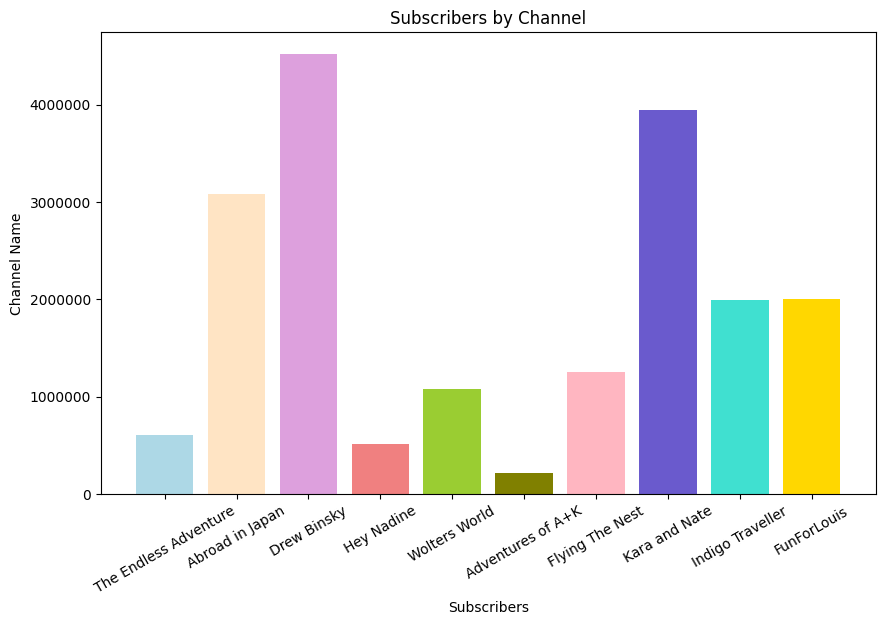

In [42]:
# Plotting the number of subscribers
fig_sub = plt.figure(figsize = (10,6))

plt.bar(channel_data['channelName'], channel_data['subscribers'], color=color)
plt.xlabel('Subscribers')
plt.ylabel('Channel Name')
plt.title('Subscribers by Channel')
plt.xticks(rotation=30)
plt.ticklabel_format(axis='y', style='plain')
plt.show()

Next, let's plot the number of views by channel.

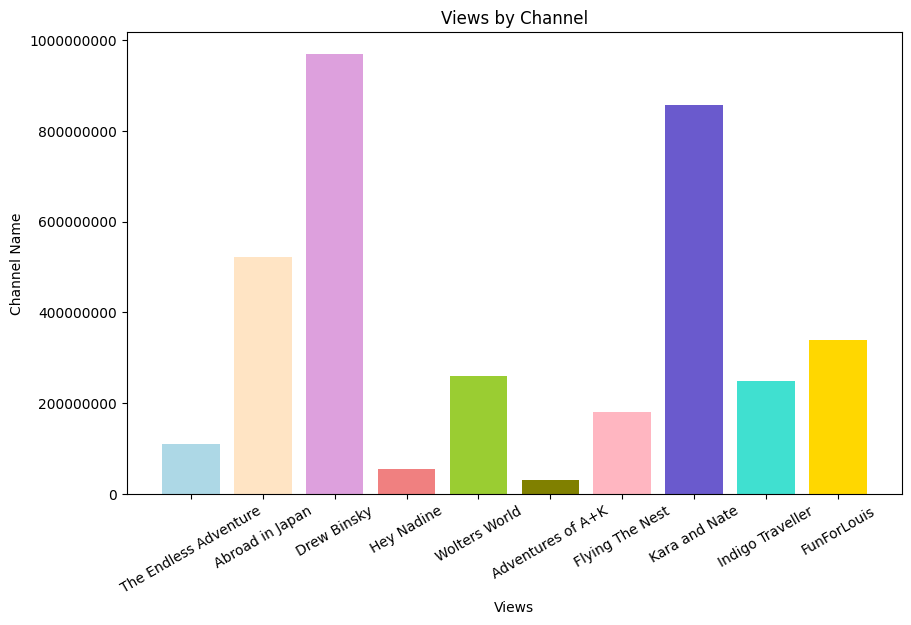

In [67]:
# Plotting the number of views
fig_sub = plt.figure(figsize = (10,6))

plt.bar(channel_data['channelName'], channel_data['views'], color=color)
plt.xlabel('Views')
plt.ylabel('Channel Name')
plt.title('Views by Channel')
plt.xticks(rotation=30)
plt.ticklabel_format(axis='y', style='plain')
plt.show()

From the 2 figures above, we can easily notice a similar ranking of channels in terms of subscribers and views. `Drew Binsky` and `Kara and Nate` are the top 2 most popular channels. For most channels, higher subscribers tend to translate into more views. However, `Indigo Traveller` has roughly the same number of subscribers as `FunForLouis` but has much fewer views. The same trend applies to the case of `Wolters World` and `Flying The Nest` as the former has fewer subsribers but way more views.

## Video Statistics of All Channels

Next, we proceed to getting video statistics of all channels by creating some functions to do that. We first obtain the video IDs and then video details of all videos of all channels.

In [44]:
def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []

    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids


In [45]:
def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

In [128]:
# Create a dataframe with video statistics and comments from all channels

video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)

    # append video data together and comment data together
    video_df = video_df._append(video_data, ignore_index=True)

Getting video information from channel: The Endless Adventure
Getting video information from channel: Abroad in Japan
Getting video information from channel: Drew Binsky
Getting video information from channel: Hey Nadine
Getting video information from channel: Wolters World
Getting video information from channel: Adventures of A+K
Getting video information from channel: Flying The Nest
Getting video information from channel: Kara and Nate
Getting video information from channel: Indigo Traveller
Getting video information from channel: FunForLouis


Let's take a look at the data we get so far.

In [129]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,mkYyNFRwFUs,The Endless Adventure,Cleanup Begins! 😱 Can We Gut & Renovate This A...,We're officially starting the cleanup process ...,"[The Endless Adventure, Eric Bieller, Allison ...",2024-09-04T19:23:07Z,10142,2308,None,139,PT19M24S,hd,true
1,RmFGMCJG5ls,The Endless Adventure,We Bought an Old Abandoned Ranch House in Texa...,We finally did it. We bought a freaking house!...,"[The Endless Adventure, Eric Bieller, Allison ...",2024-08-22T18:46:05Z,117319,10588,None,1298,PT21M5S,hd,true
2,tp2iBoxV820,The Endless Adventure,Our Final Day of Full-Time RV Life Was a DISAS...,Our final road trip in the RV was AWFUL! The m...,"[The Endless Adventure, Eric Bieller, Allison ...",2024-08-12T17:58:06Z,114000,9023,None,387,PT19M33S,hd,false
3,MCTobf4S8uE,The Endless Adventure,We Found Mexico’s HIDDEN Wine Country! 😍 Luxur...,We're taking a break from Mexico RV life to ex...,"[The Endless Adventure, Eric Bieller, Allison ...",2024-08-02T16:31:28Z,78279,6472,None,218,PT20M8S,hd,false
4,WCREq79nm0I,The Endless Adventure,The ULTIMATE RV Road Trip Through BAJA! - Our ...,Today we’re driving our camper van RV up the M...,"[The Endless Adventure, Eric Bieller, Allison ...",2024-07-23T18:46:29Z,81274,6858,None,198,PT19M45S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10761,7xCdhXjzHeE,FunForLouis,Drumming and Abandoned Buildings | UK Roadtrip...,Make sure you subscribe for more daily vlogs!\...,"[daily vlogs, louis cole, foodforlouis, food f...",2012-11-15T00:58:16Z,94883,1957,None,171,PT4M30S,hd,false
10762,CyrRuBsWpMk,FunForLouis,Yoda Loves Dj-ing | UK Roadtrip Day 1,Make sure you subscribe for more daily vlogs!\...,"[\daily vlogs\, \louis, cole\, \foodforlouis\,...",2012-11-13T17:25:24Z,169900,3147,None,252,PT3M24S,hd,true
10763,C6kXGdqlzOw,FunForLouis,Adventure Vlog | Park Ranger Trouble,A short Adventure Vlog documenting what happen...,"[Adventure Vlog, prefekt, santa cruz, Californ...",2012-07-19T13:19:21Z,91285,1110,None,64,PT1M11S,hd,false
10764,fvrDMGgNMHg,FunForLouis,Norway Roadtrip 2012 | part 2 | Fun For Louis,"The Second of two episodes, Louis and friends ...","[Road, trip, road trip, roadtrip, louis cole, ...",2012-05-28T20:54:15Z,110285,2577,None,423,PT9M59S,hd,false


So our video dataset has a total of 10,766 videos. Let's also save this as a csv file for future use or reference.

In [130]:
# Write video data to CSV file for future references
video_df.to_csv('video_data_top10_channels.csv')

## Data Preprocessing & Feature Engineering

Now, let's check the information of our video dataset.

In [132]:
# Show data info
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10766 entries, 0 to 10765
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        10766 non-null  object
 1   channelTitle    10766 non-null  object
 2   title           10766 non-null  object
 3   description     10766 non-null  object
 4   tags            10020 non-null  object
 5   publishedAt     10766 non-null  object
 6   viewCount       10765 non-null  object
 7   likeCount       10761 non-null  object
 8   favouriteCount  0 non-null      object
 9   commentCount    10742 non-null  object
 10  duration        10766 non-null  object
 11  definition      10766 non-null  object
 12  caption         10766 non-null  object
dtypes: object(13)
memory usage: 1.1+ MB


In [133]:
video_df.isnull().sum()

video_id              0
channelTitle          0
title                 0
description           0
tags                746
publishedAt           0
viewCount             1
likeCount             5
favouriteCount    10766
commentCount         24
duration              0
definition            0
caption               0
dtype: int64

As some columns are not in the right format, let's convert them to the right data type.

In [134]:
# Convert columns to numeric values
cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

Now, let's check if the date column (`publishedAt`) has any issues.

In [135]:
video_df.publishedAt.sort_values().value_counts()

publishedAt
2020-11-18T00:09:45Z    5
2019-03-19T14:00:03Z    2
2019-11-28T18:00:00Z    2
2019-03-10T15:00:01Z    2
2021-09-12T15:00:03Z    2
                       ..
2016-05-22T17:24:08Z    1
2016-05-22T21:09:08Z    1
2016-05-23T01:59:36Z    1
2016-05-23T10:00:01Z    1
2024-09-04T19:23:07Z    1
Name: count, Length: 10747, dtype: int64

Here we can see that all videos were published between 2016 and 2024. The dates look right.

For further analysis of our data, let's create some more variables from the current ones, including:

* the published day (of the week) of each video
* video duration in seconds instead of the current string format
* the number of tags for each video
* the ratio of comments and likes per 1000 views
* title character length

In [136]:
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['publishedDay'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [137]:
# Convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())


In [138]:
# Calculate the number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [139]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [140]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

Now, let's look at the final dataset we have created for analysis.

In [141]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDay,durationSecs,tagsCount,likeRatio,commentRatio,titleLength
0,mkYyNFRwFUs,The Endless Adventure,Cleanup Begins! 😱 Can We Gut & Renovate This A...,We're officially starting the cleanup process ...,"[The Endless Adventure, Eric Bieller, Allison ...",2024-09-04 19:23:07+00:00,10142.0,2308.0,NaN,139.0,PT19M24S,hd,true,Wednesday,1164.0,9,227.568527,13.705384,70
1,RmFGMCJG5ls,The Endless Adventure,We Bought an Old Abandoned Ranch House in Texa...,We finally did it. We bought a freaking house!...,"[The Endless Adventure, Eric Bieller, Allison ...",2024-08-22 18:46:05+00:00,117319.0,10588.0,NaN,1298.0,PT21M5S,hd,true,Thursday,1265.0,11,90.249661,11.063852,76
2,tp2iBoxV820,The Endless Adventure,Our Final Day of Full-Time RV Life Was a DISAS...,Our final road trip in the RV was AWFUL! The m...,"[The Endless Adventure, Eric Bieller, Allison ...",2024-08-12 17:58:06+00:00,114000.0,9023.0,NaN,387.0,PT19M33S,hd,false,Monday,1173.0,13,79.149123,3.394737,63
3,MCTobf4S8uE,The Endless Adventure,We Found Mexico’s HIDDEN Wine Country! 😍 Luxur...,We're taking a break from Mexico RV life to ex...,"[The Endless Adventure, Eric Bieller, Allison ...",2024-08-02 16:31:28+00:00,78279.0,6472.0,NaN,218.0,PT20M8S,hd,false,Friday,1208.0,16,82.678624,2.784910,97
4,WCREq79nm0I,The Endless Adventure,The ULTIMATE RV Road Trip Through BAJA! - Our ...,Today we’re driving our camper van RV up the M...,"[The Endless Adventure, Eric Bieller, Allison ...",2024-07-23 18:46:29+00:00,81274.0,6858.0,NaN,198.0,PT19M45S,hd,false,Tuesday,1185.0,18,84.381229,2.436203,96


## Exploratory Data Analysis (EDA)

### Distribution of Views by Channel

/var/folders/16/cly8b38n7ks2zpvg32s_46wm0000gn/T/ipykernel_38877/644841011.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = video_df, x = video_df['channelTitle'], y = video_df['viewCount'], palette='pastel')


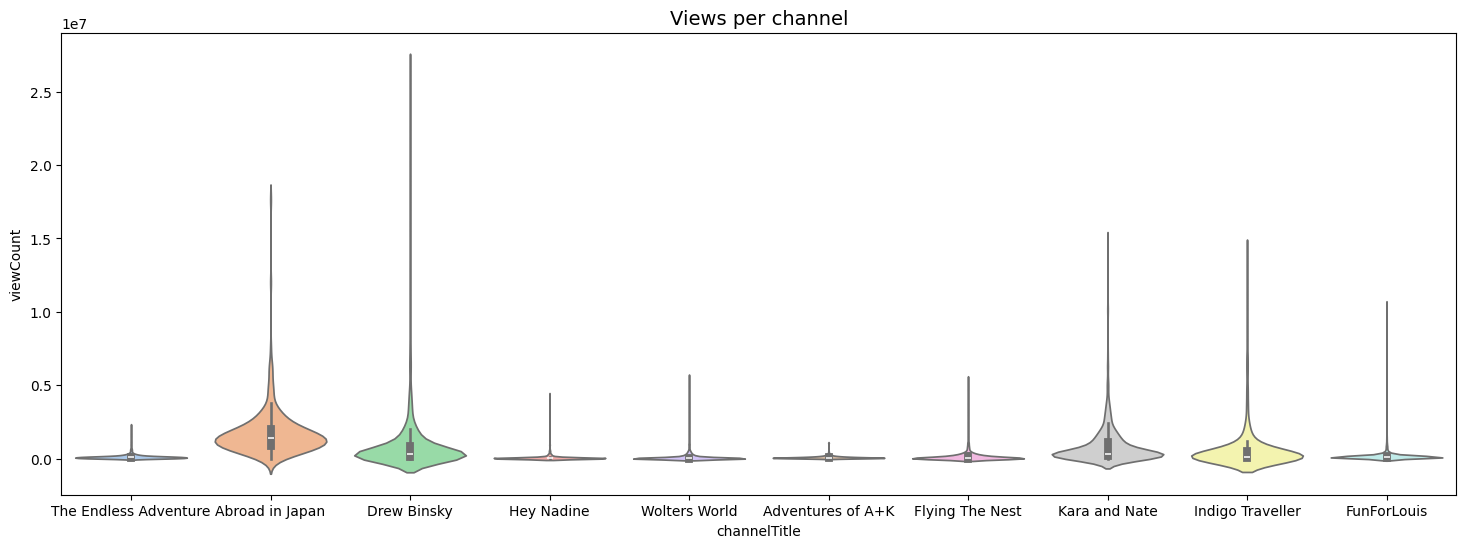

In [160]:
# View distribution of channels
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(data = video_df, x = video_df['channelTitle'], y = video_df['viewCount'], palette='pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()

Some channels might have a lot of views on one of their videos and the rest do not receive as many. Other channels might have a more even distribution of views. It can be observed that all channels, except for `Abroad in Japan`, `Drew Binsky`, `Kara and Nate`, and `Indigo Traveller`, have a small variance in their views: their total views are lower but are distributed more evenly across their videos. The 4 mentioned channels are more popular in terms of total views but have a quite large variance in their views, suggesting that they have a few viral videos.

### Does the Number of Likes and Comments Matter for a Video to Get More Views?

Firstly, I would like to check if comments and likes do correlate with how many views a video would get.

<Axes: xlabel='likeCount', ylabel='viewCount'>

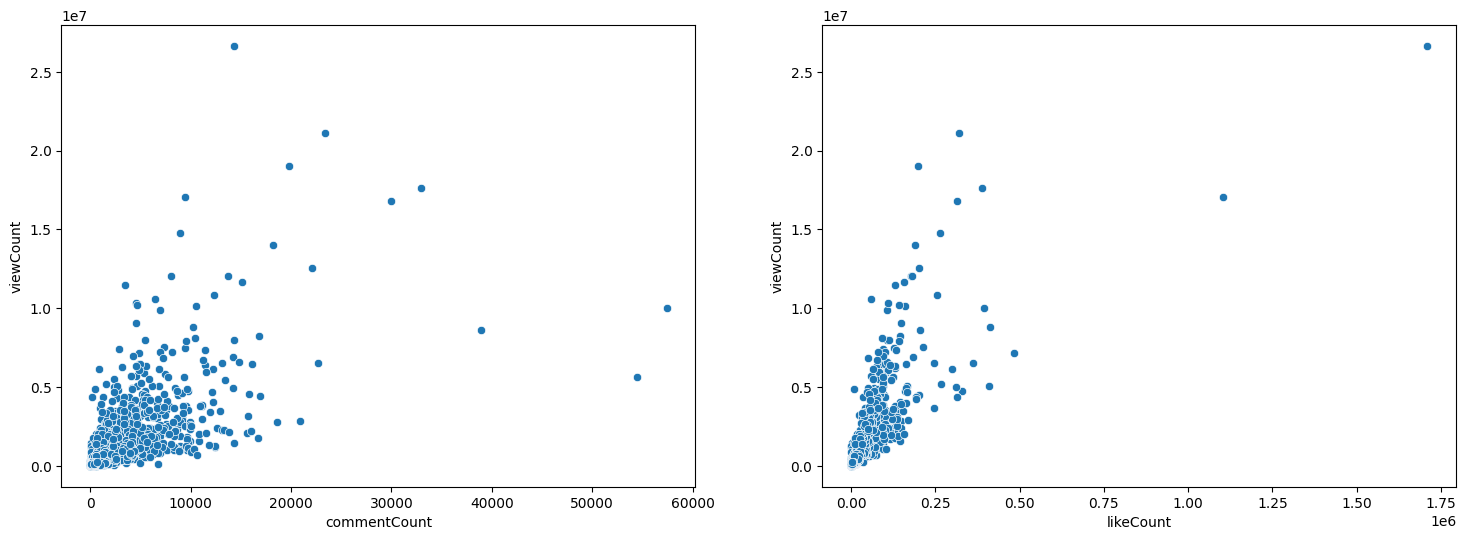

In [143]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

In the plot above when plotting the number of views against the number of comments/likes, it can be observed that they strongly correlated with each other. The number of likes seems to suggest a stronger, more positive correlation than the number of comments. However, this is expected as the more people watching a video, the more likely this video will get comments and likes. To account for this factor, we will plot these relationships again using the comments per 1000 view and likes per 1000 view ratios.

<Axes: xlabel='likeRatio', ylabel='viewCount'>

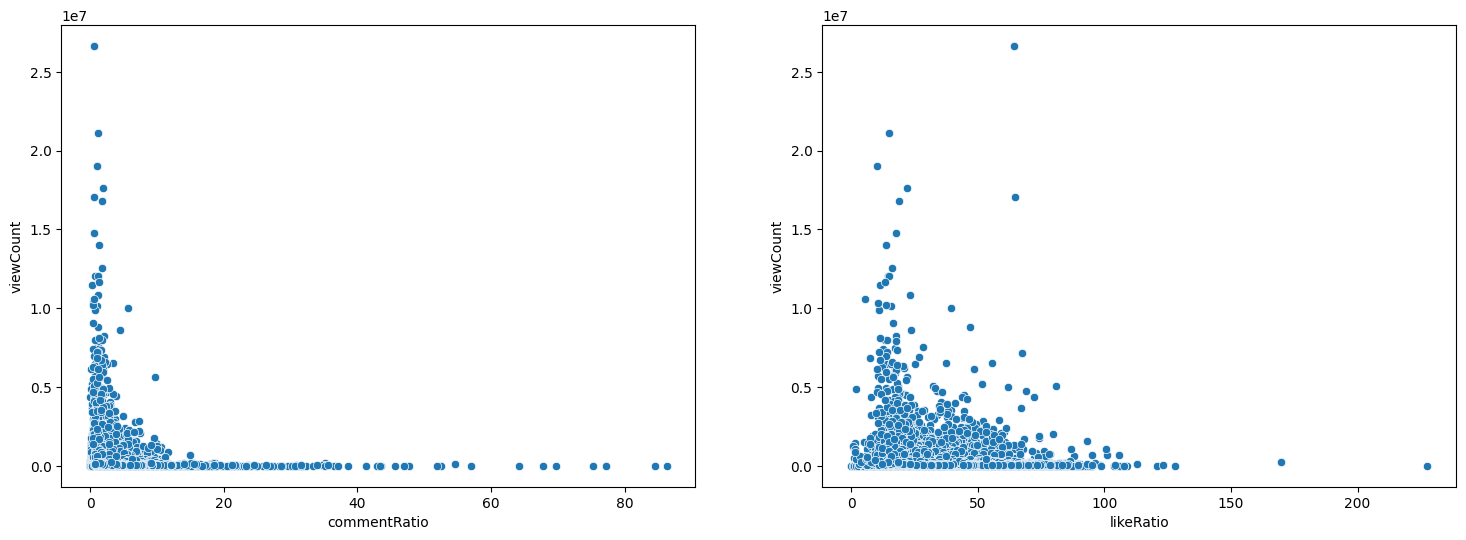

In [144]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

After correcting for the absolute number of views, it turns out that the correlation is much less clear. The comment-view relationship seems to completely disappear: a lot of videos have millions of views and very few comments, while some vides with much fewer views have better interaction. However, it is understandable that comments take more effort than views and likes, and normally comments would die off when the video gets older.

As for like-view relatioship, the correlation also fades away. This does not seem to support the idea of social proof that people tend to like the products that are already liked by many other people.

### Does the Video Duration Matter for Views and Interaction (Likes/ Comments)?


<Axes: xlabel='durationSecs', ylabel='Count'>

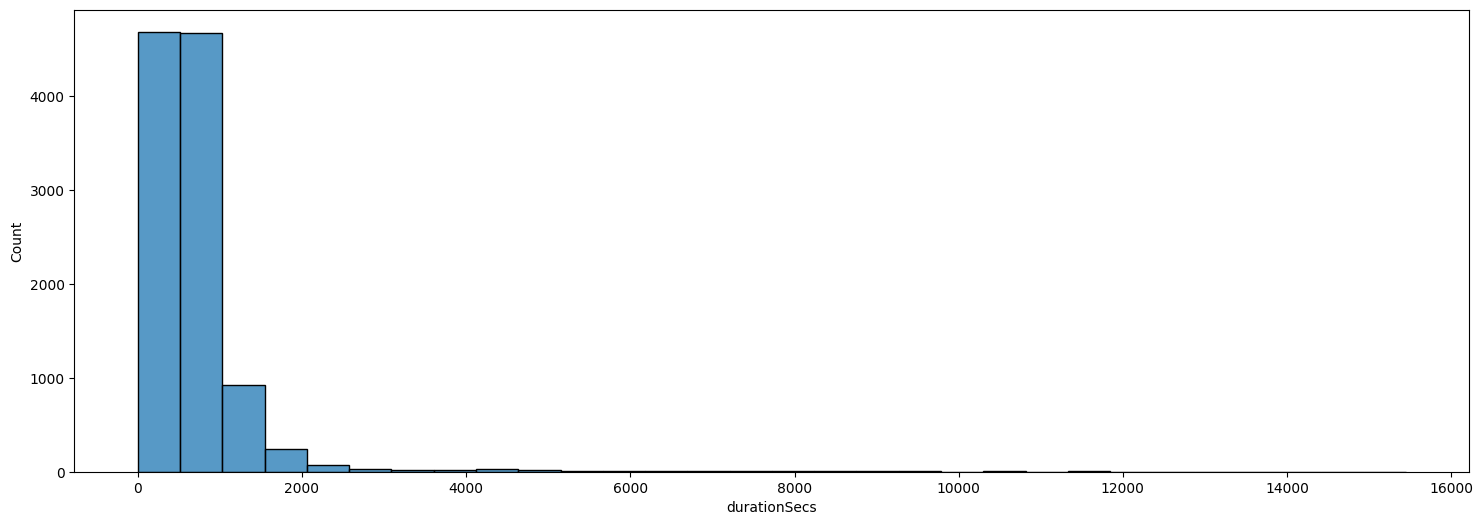

In [145]:
sns.histplot(data=video_df, x=video_df['durationSecs'], bins=30)


As seen in the histogram above, most videos are shorter than 1000 seconds, which is about 16 minutes.

<Axes: xlabel='durationSecs', ylabel='likeCount'>

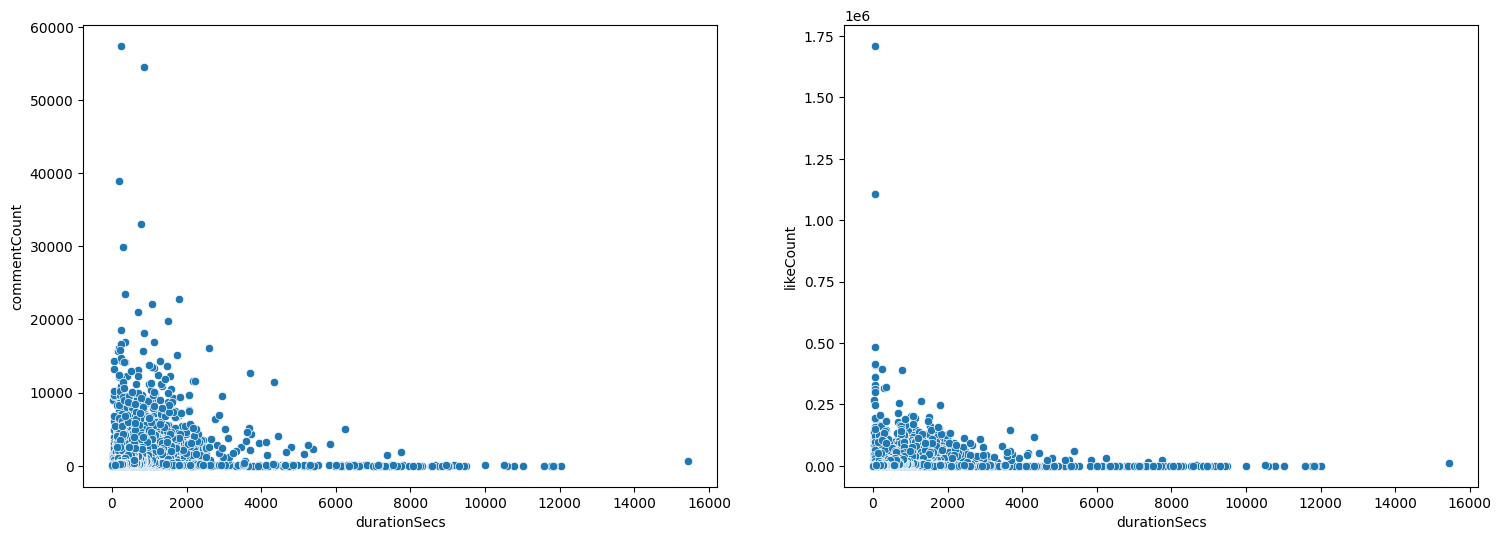

In [146]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

When plotting video duration against comment count and like count, we do not see a strongly correlated relationship between them. However, it can be observed that shorter videos tend to get more likes and comments than very long videos.

### Does Title Length Matter for Views?

<Axes: xlabel='titleLength', ylabel='viewCount'>

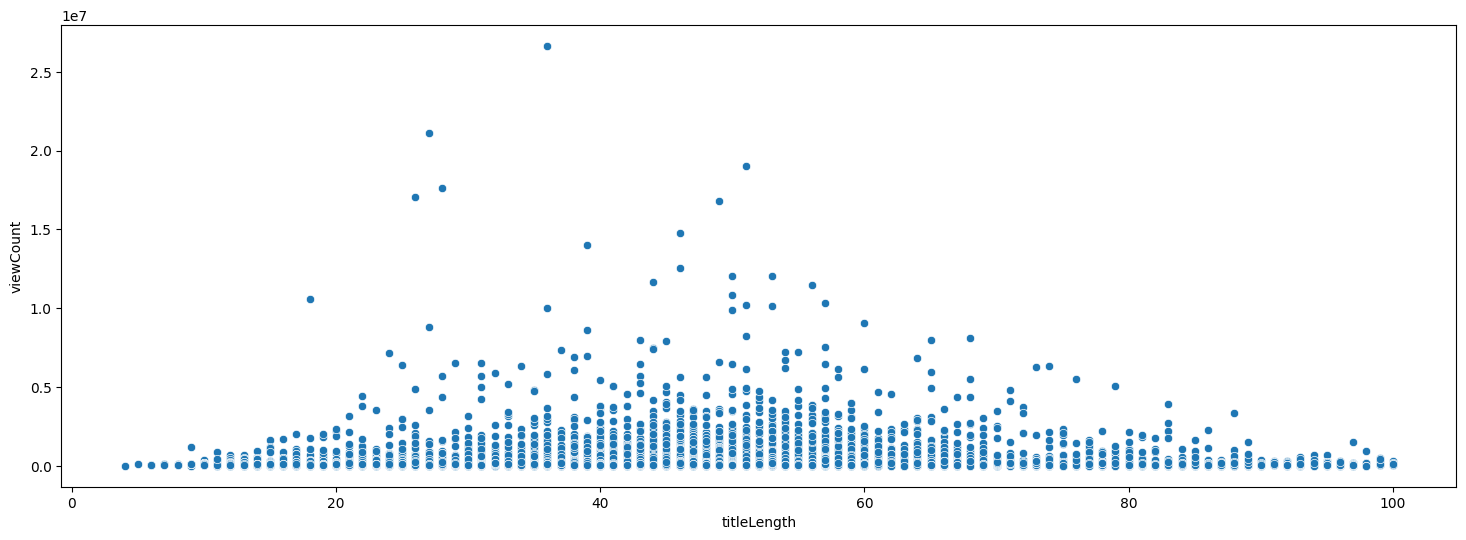

In [147]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

As the above figure suggests, there is no clear relationship between title length and views, but most-viewed videos tend to have average title length of 25 - 50 characters.

### Number of Tags vs Views

<Axes: xlabel='tagsCount', ylabel='viewCount'>

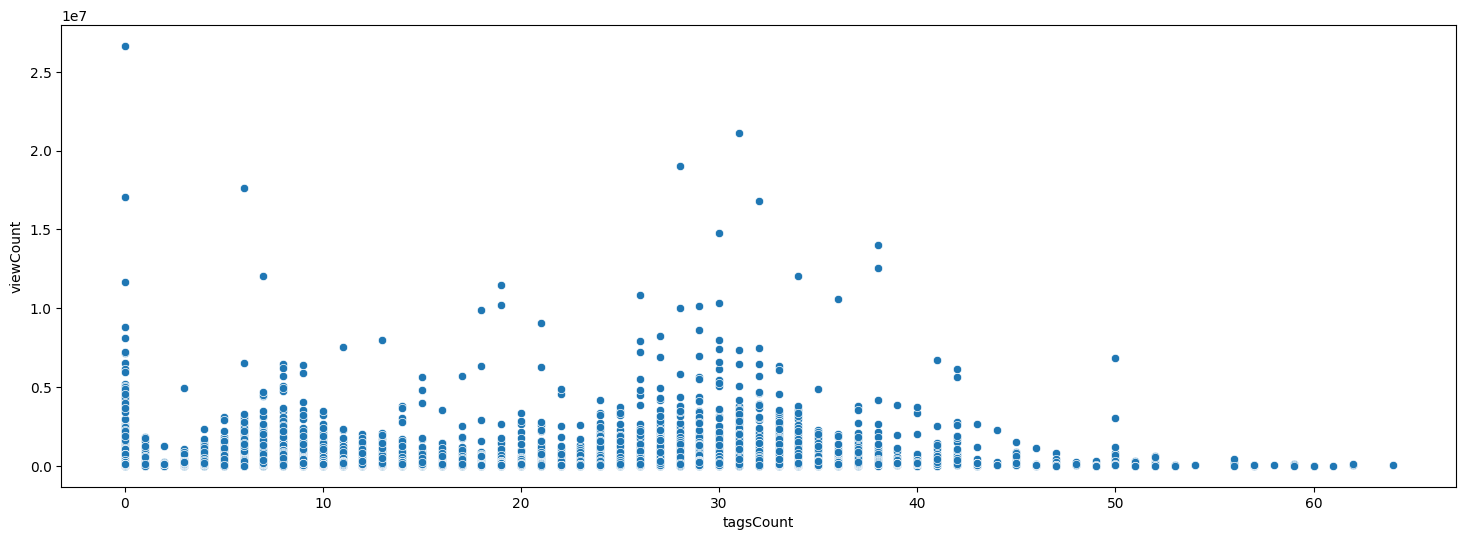

In [156]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

Similarly, we cannot detect a clear relationship between the number of tags and view count. Most-viewed videos have fewer than 35 tags.

### Day Uploaded vs Views

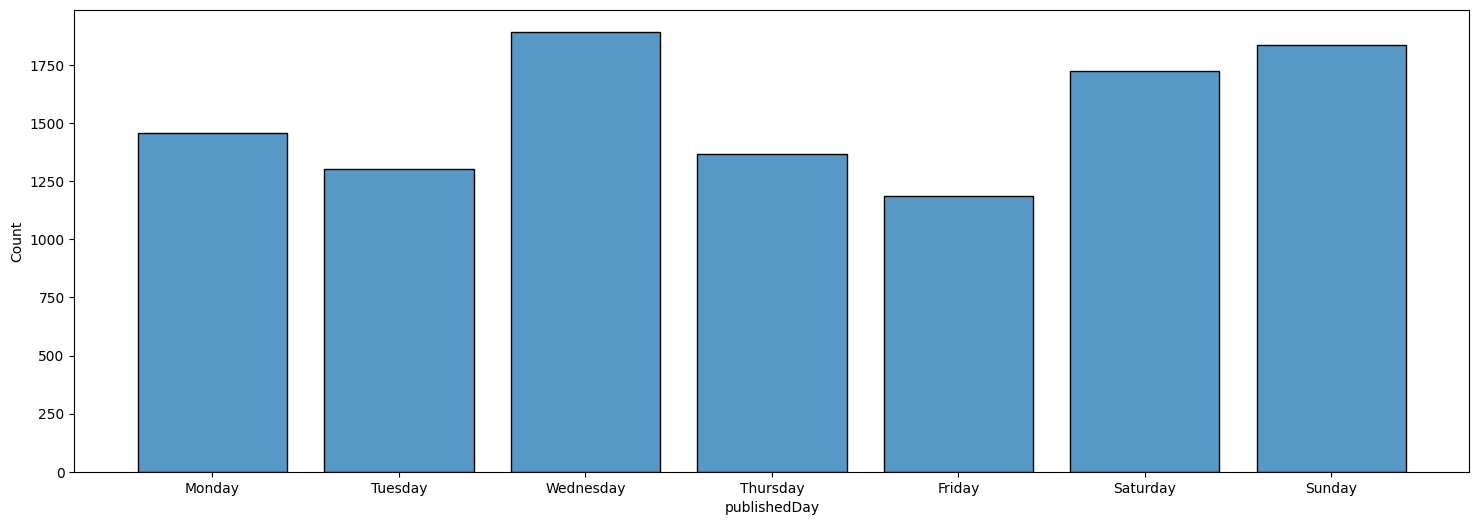

In [155]:
# Define the correct order for days of the week
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'publishedDay' to a categorical type with the correct order
video_df['publishedDay'] = pd.Categorical(video_df['publishedDay'], categories=weekdays, ordered=True)

# Plot the histogram
sns.histplot(data=video_df, x='publishedDay', bins=7, shrink=0.8)

# Show the plot
plt.show()

Interestingly, there is no particular day of the week that sees more videos uploaded. Wednesdays seem to be the most popular while Fridays are the least chosen time for video uploading. Let's see how view count fluctuates with days of the week.

/var/folders/16/cly8b38n7ks2zpvg32s_46wm0000gn/T/ipykernel_38877/1317516376.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  views_by_day = video_df.groupby('publishedDay')['viewCount'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


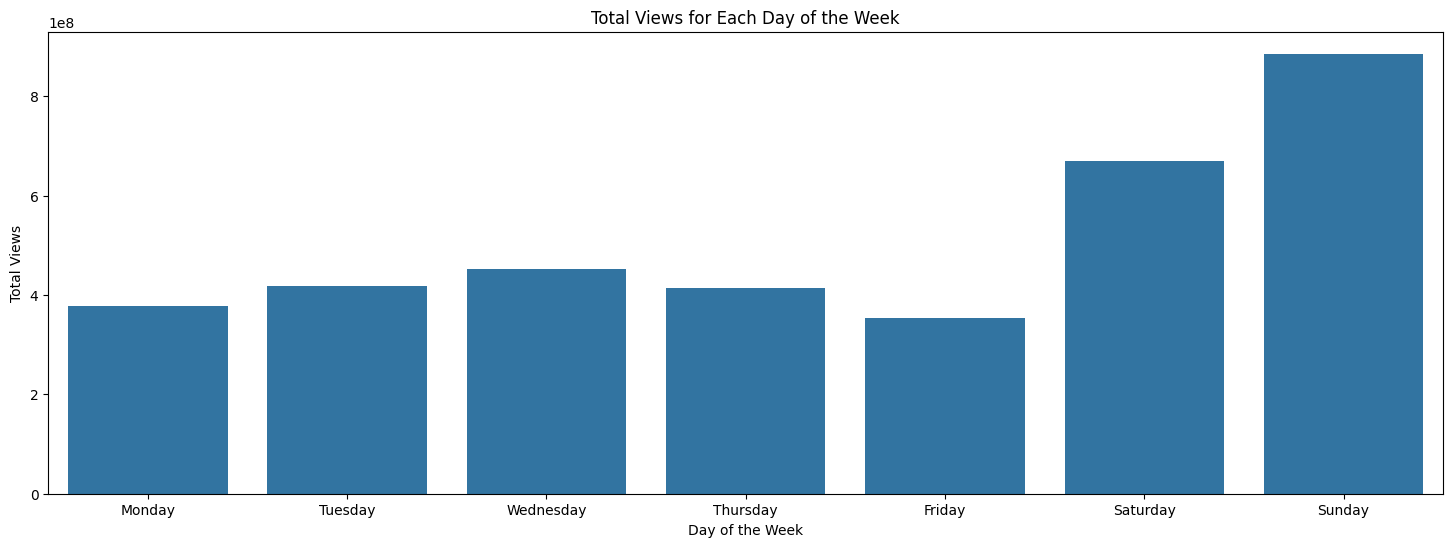

In [165]:
# Group by 'publishedDay' and sum 'viewCount'
views_by_day = video_df.groupby('publishedDay')['viewCount'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the total views for each day of the week
sns.barplot(x=views_by_day.index, y=views_by_day.values)

plt.xlabel('Day of the Week')
plt.ylabel('Total Views')
plt.title('Total Views for Each Day of the Week')
plt.show()

Now we can clearly see that videos posted on Sundays have the most views, followed by Saturday. Videos posted on weekdays all have lower total views compared to those uploaded on the weekend. This is understandable as the general audience would have more free time on the weekend to watch Youtube.

### Does Having Caption Matter for Views?

In the dataset, there are videos with and without caption. First, let's see the count distribution of each group.

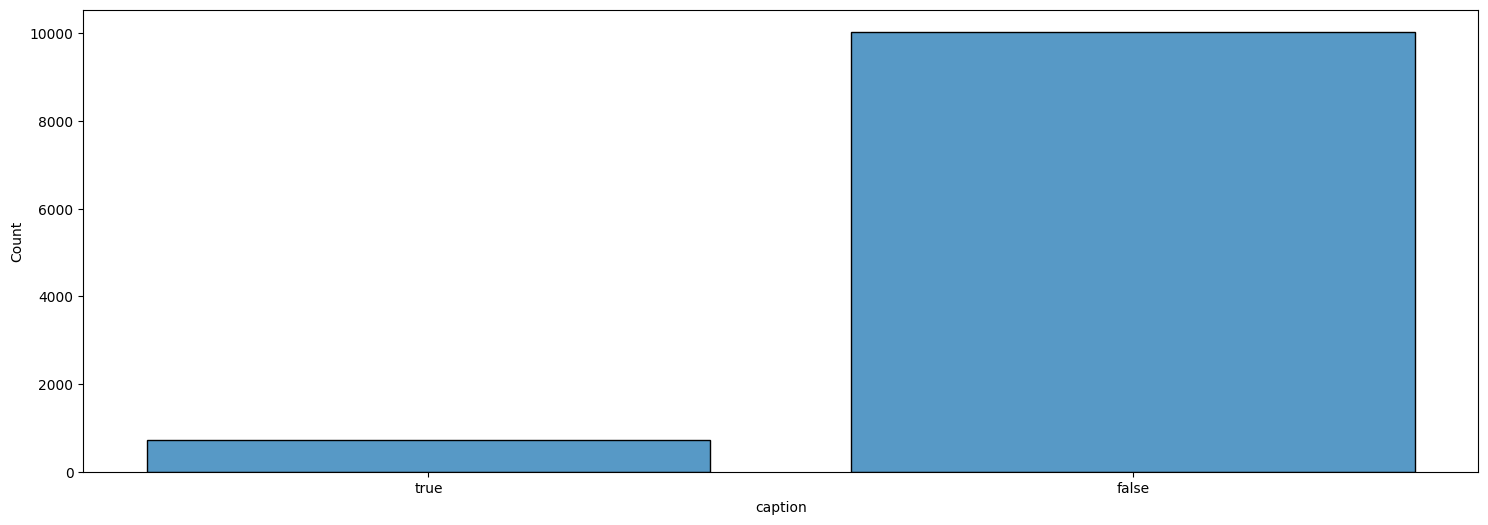

In [169]:
sns.histplot(data=video_df, x='caption', bins=2, shrink=0.8)
plt.show()

So the majority of the videos do not have caption. So it is expected if videos without a caption get a higher total of views, as it is simply because there are more of them. Let's check this.

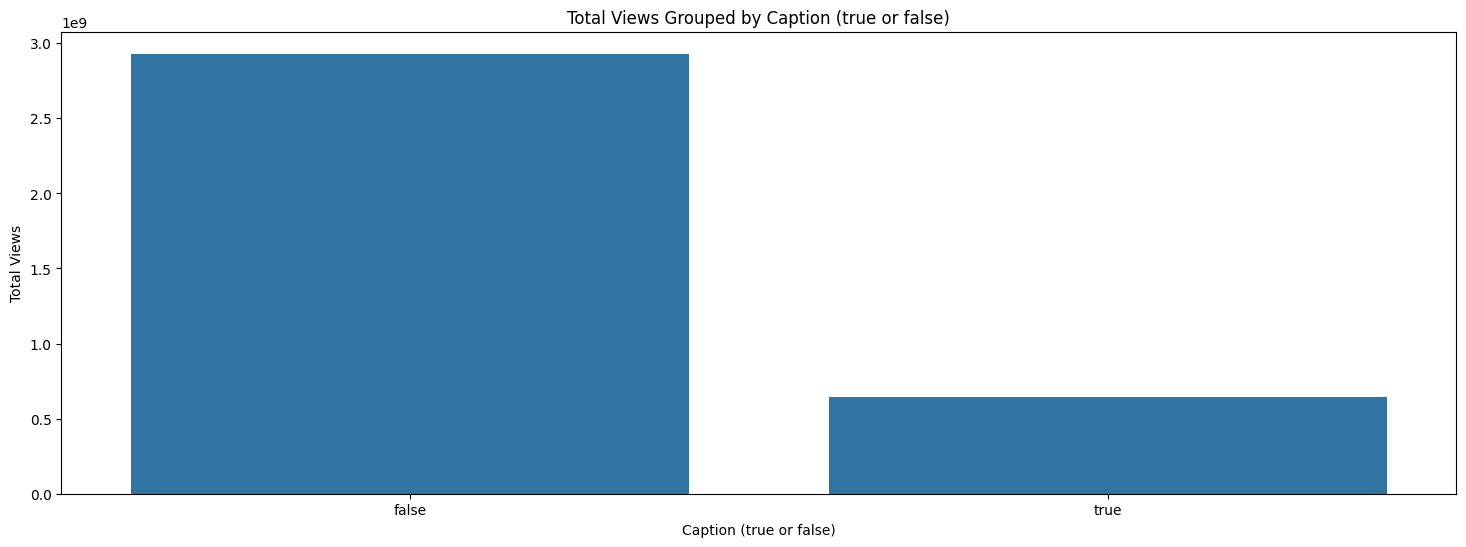

In [182]:
# Group by 'caption' and sum 'viewCount'
views_by_caption = video_df.groupby('caption')['viewCount'].sum()

# Plot the total views for each caption group (TRUE or FALSE)
sns.barplot(x=views_by_caption.index, y=views_by_caption.values)

plt.xlabel('Caption (true or false)')
plt.ylabel('Total Views')
plt.title('Total Views Grouped by Caption (true or false)')
plt.show()


So as we expected, views of videos without caption outnumber those of videos without. But this does not mean much to us.

I'm interested in testing whether having caption makes a video have more views or likes. To answer this question, I will conduct a two sample t-test to test for a statistically significant difference in the means between 2 groups (with caption and without caption).

Let's write down the hypothesis for this test:

$H_0: \mu_1 - \mu_2 = 0$

$H_1: \mu_1 - \mu_2 \neq 0$

With $\mu_1, \mu_2$ being the mean of groups 1 and 2.

Before performing this test, we need to check 2 groups' variance to make sure they have the same, or similar variance.

In [176]:
# Split data into two groups based on caption
with_caption = video_df[video_df['caption'] == 'true']['viewCount']
without_caption = video_df[video_df['caption'] == 'false']['viewCount']

# Calculate the variance
print(f"Variance for videos with captions: {with_caption.var()}")
print(f"Variance for videos without captions: {without_caption.var()}")
print(f"Variance Ratio: {with_caption.var()/without_caption.var()}")


Variance for videos with captions: 2636491672653.1025
Variance for videos without captions: 741742556992.1698
Variance Ratio: 3.5544565264588623


Here, the ratio is roughly 3.55, which is less than 4:1. So we can proceed with the two-sample t-test.

First, I notice a missing value in without_caption, so I will drop it as this t-test function cannot handle missing values.

In [191]:
# Drop the missing value in the without_caption group
without_caption = without_caption.dropna()

# Perform the two sample t-test with equal variances
stats.ttest_ind(a=with_caption, b=without_caption, equal_var=True)

TtestResult(statistic=16.52191020589111, pvalue=1.417397690148181e-60, df=10763.0)

The test outputs a p-value of 1.42e-60, which is extremely small (close to zero). Therefore, we reject the null hypothesis that there is no statistical difference between the means of 2 groups. In order words, statistically speaking, there is a significant difference in view counts between videos with captions and videos without captions.

### Wordcloud for Words in Title

As I'm interested to see what the creators are making videos about and which terms most frequently appear in their video titles, I will create a wordcloud for the most common words. We first need to remove the stopwords such as "you," "I," "the," etc., which do not contribute a lot to the meaning of the title.

In [148]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

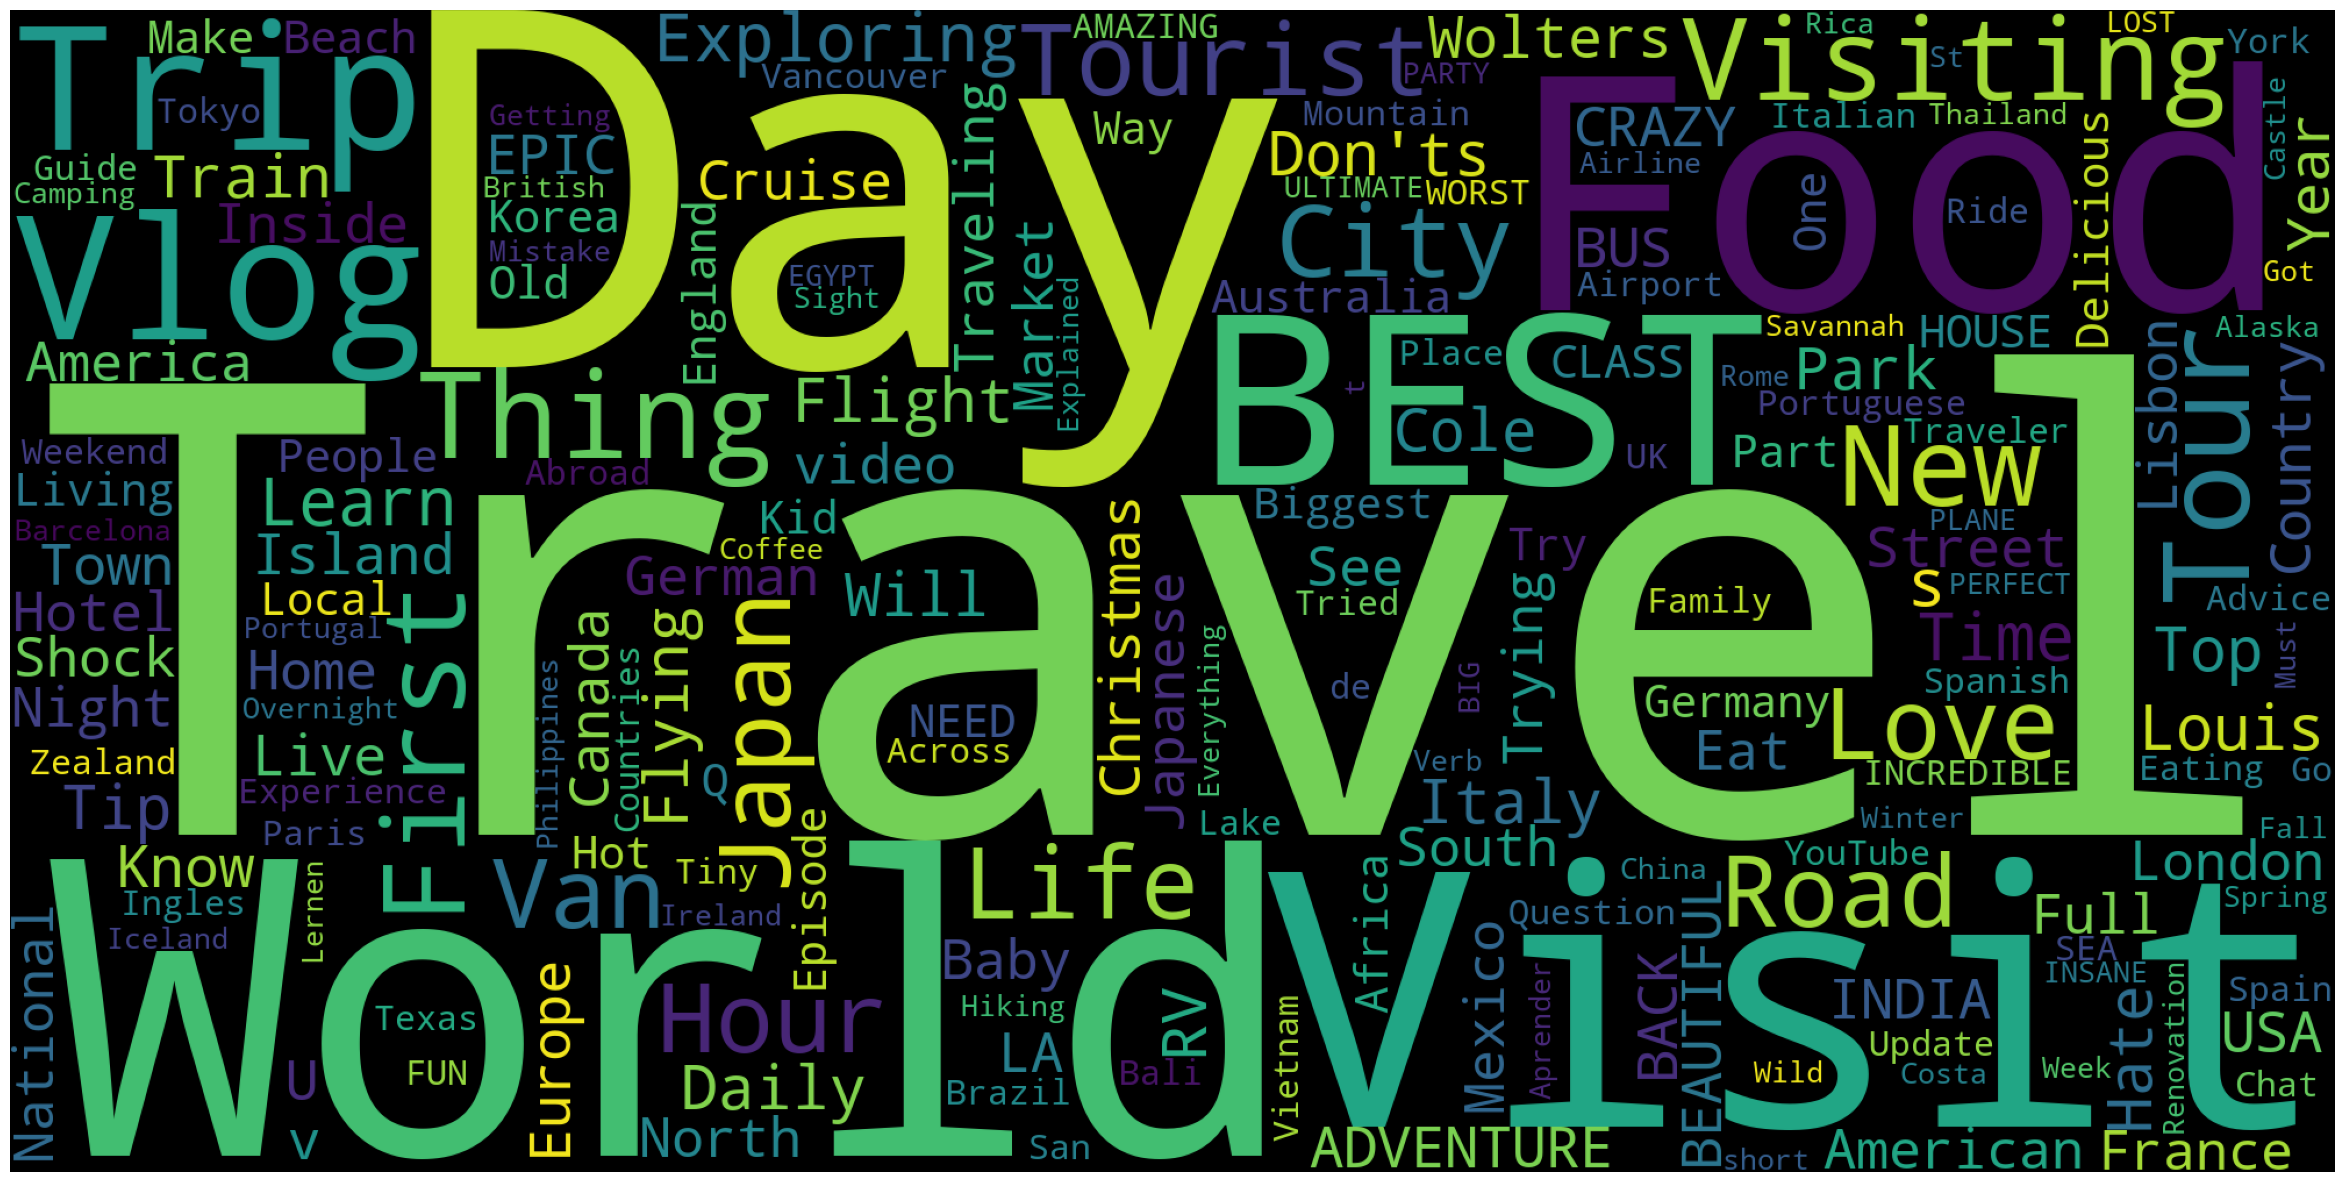

In [149]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

Now we can see that the most common words in the title are: Travel, World, Visit, Food, Day, Best, Trip, etc. These are all very relevant to the topic of these channels.

## Conclusions and Future Considerations

In this project, we have explored the video data of the 10 most popular Youtube travel channels and revealed many interesting findings:
* There is no clear correlation between comments per 1000 view ratio and likes per 1000 view ratio and view counts.
* Most videos are shorter than 1000 seconds, which is about 16 minutes.
* Shorter videos tend to get more likes and comments than very long videos.
* Most-viewed videos tend to have average title length of 25 - 50 characters. Too short or too long titles seem to harm viewership.
* Most-viewed videos have fewer than 35 tags.
* There is no particular day that sees more new uploaded but videos uploaded on the weekend get more views than on weekdays.
* There is a statistically significant difference in view counts between videos with captions and videos without captions.

### Project Limitations & Future Considerations

There are certain limitations in this project that should be taken into account:
* The dataset is not large, around 10,700 videos.
* The comment data was not included due to Youtube API's quota limit.
* There are other factors driving views that are not considered in this project, including but not limited to marketing campaign of the content creators, government censorship, and Youtube's recommendation mechanism.

With this acknowledgement, future considerations may include:
* Expanding the dataset to more channels within the same topic (e.g. travel).
* Including comment data and performing sentiment analysis to find out which videos tend to get more positive/negative comments.
* Conduct this research for other niches (e.g. language learning, beauty channels), to compare different niches with each other to see the different patterns in viewership and video characteristics.